In [1]:
import sys
import os
sys.path.insert(0,'../classes')
sys.path.insert(0,'../analysis')
import anl

sys.path.insert(0,'/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new')
hqfd = '/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new/Heuristic quality'
sys.path.insert(0,hqfd)
from fourinarowfunctions import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

import tournament
# participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_4' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_4'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/'

import load
import plot_fun
from importlib import reload
reload(load)

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!


<module 'load' from '../analysis/load.py'>

In [2]:
import value_analysis as va
import pandas as pd
import create_database as cd
all_players = pd.read_pickle(cd.DATABASE_LOC)

In [3]:
import tournament_new as tn
game = Game(4,9,4)
one_info = all_players.loc[all_players['id']=='tournament_6;mcts100;cpuct2;id-0;best'].iloc[0]
ai,val_func,tree = tn.get_player(game, one_info)

In [112]:
opt_boards, opt_values=va.load_opt_value_test_boards()

In [5]:
opt_boards[10]

array([[ 0,  0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  1, -1,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0, -1,  0,  0],
       [ 0,  0,  1,  0, -1,  0, -1,  0,  0]])

In [6]:
b = game.getInitBoard()
b[0,:3]=1

In [7]:
b

array([[1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
val_func.nnet.model.layers

In [5]:
model = val_func.nnet.model

In [14]:
from tensorflow.python.keras import backend
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, backend.symbolic_learning_phase()], [out]) for out in outputs]    # evaluation functions

# Testing
# test = np.random.random([4,9])[np.newaxis,...]
# test = opt_boards[10:12]
test = b[None,:,:]
layer_outs = [func([test, False]) for func in functors]
# print(layer_outs)

In [46]:
model.layers

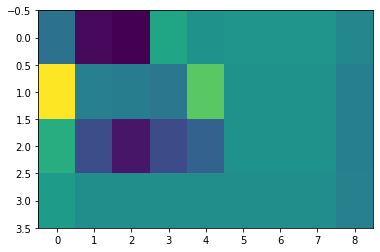

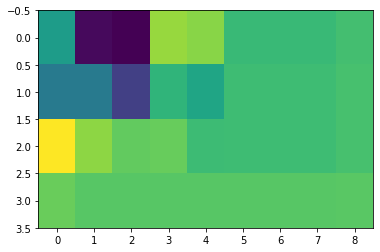

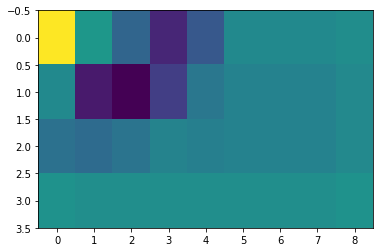

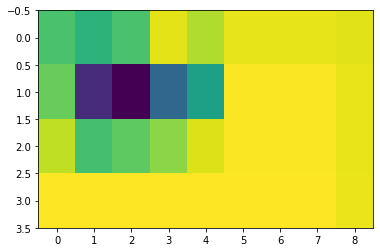

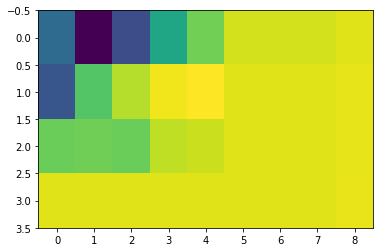

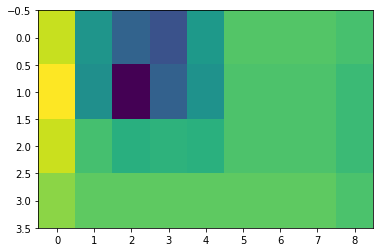

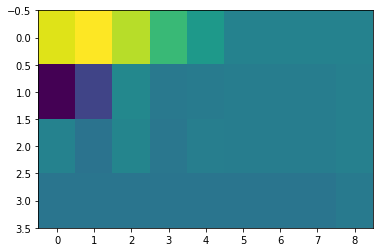

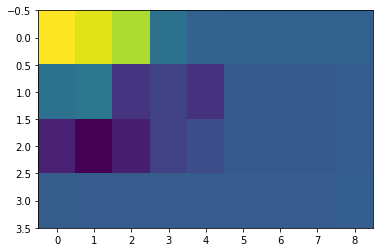

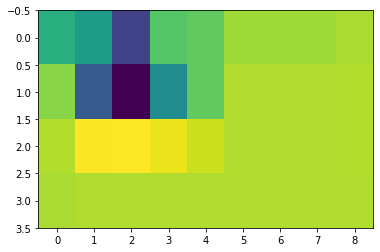

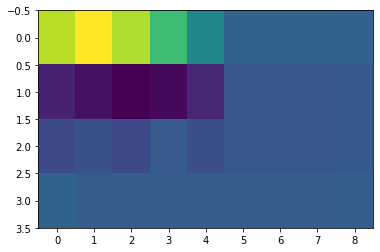

In [16]:
kk=0
l=6
for c in range(10):
    plt.figure()
    plt.imshow(layer_outs[l][0][kk][:,:,c],aspect='auto')

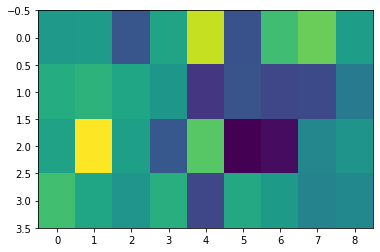

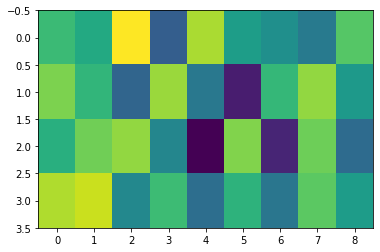

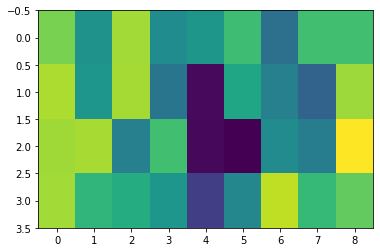

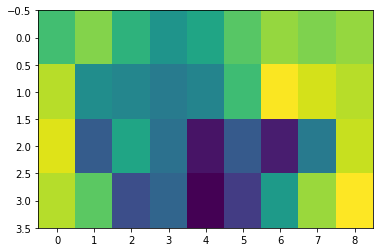

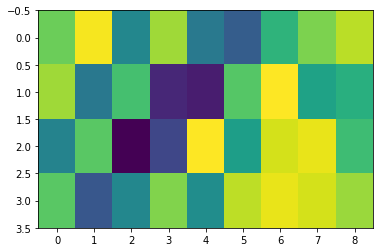

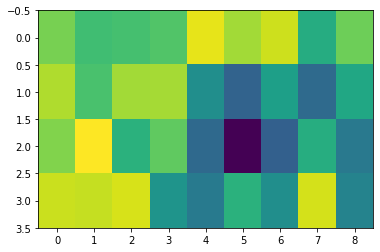

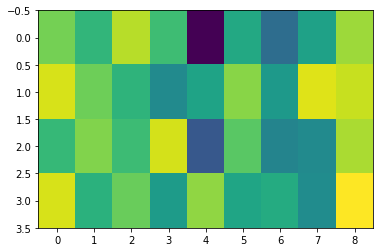

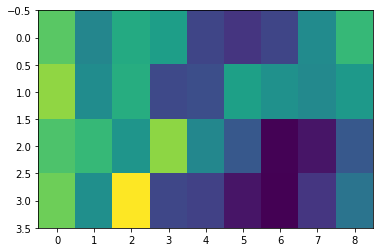

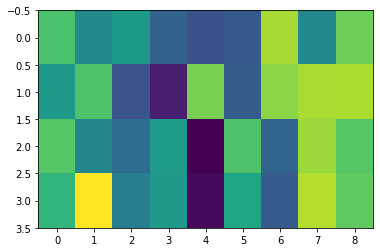

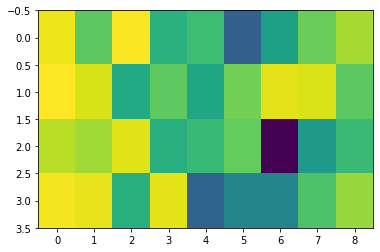

In [25]:
kk=0
l=6
for c in range(10):
    plt.figure()
    plt.imshow(layer_outs[l][0][kk][:,:,c],aspect='auto')

In [22]:
model.layers[-4].output

<tf.Tensor 'activation_5/Identity:0' shape=(None, 512) dtype=float32>

In [6]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import initializers
from keras import regularizers
import keras
import tensorflow as tf

In [264]:
from keras.constraints import Constraint
from keras import backend as K

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, low=0,high=1):
        self.low = low
        self.high = high

    def __call__(self, p):
        return K.clip(p, -self.low, self.high)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'range': (self.low,self.high)}

class Distort(keras.layers.Layer):
    def __init__(self, shape=(4,9),N_noise_samples=100,model=None,l1=0.01,noise_std=0.1,p_flip=0.2, **kwargs):
        super(Distort, self).__init__()
        self.l1 = l1
#         self.w_init = tf.random_uniform_initializer(minval=0.0,maxval=1.0) # can add in init with board input
        self.w_init = initializers.RandomUniform(minval=0.0,maxval=1.0) # can add in init with board input
#         self.w = tf.Variable(
#             initial_value=w_init(shape=shape, dtype="float32"),
#             trainable=True,
#         )
        self.N_noise_samples=N_noise_samples


        
        noise_samples=np.random.choice([-2,-1,0,1,2],p=[p_flip,p_flip,1-4*p_flip,p_flip,p_flip],size=(N_noise_samples,*shape)).astype(np.float32)
        
        self.noise_samples = tf.constant(noise_samples)
        
#         self.noise_samples = tf.Variable(
#             initial_value=noise_samples_init(shape=(N_noise_samples,*shape), dtype="float32"),
#             trainable=False,
#         )
        
#         self.noise_samples_init = initializers.RandomNormal(mean=0.0, stddev=noise_std) # if using add_weight
        self.shape=shape
        if model is not None:
            self.f = model
        else:
            self.f = tf.identity
            
    def build(self, input_shape):
        self.w = self.add_weight(
            "mask",
            shape=input_shape,
            initializer=self.w_init,
            trainable=True,
            regularizer=regularizers.l1(self.l1),
            constraint = WeightClip(low=0,high=1),
        )
#         self.noise_samples = self.add_weight(
#             "noise",
#             shape = (self.N_noise_samples,*input_shape[1:]),
#             initializer=self.noise_samples_init,
#             trainable=False,
#         )
        

    def call(self, input): # only accomodate single input example
#         return self.f(self.w * input[None,...] + (1-self.w)  * self.noise_samples)
#         w_clipped = K.clip(self.w,0,1)
#         noise_samples = np.random.normal(0,0.1,size=(self.N_noise_samples,*self.shape))
#         return self.f(self.w * input + (1-self.w)  * noise_samples)

        noise_samples=np.random.choice([-2,-1,0,1,2],p=[p_flip,p_flip,1-4*p_flip,p_flip,p_flip],size=(self.N_noise_samples,*self.shape)).astype(np.float32)
        self.noise_samples = tf.constant(noise_samples)

        distorted_in = self.w * input + (1-self.w)  * self.noise_samples
        distorted_in_clipped = K.clip(distorted_in,-1,1)
        return self.f(distorted_in_clipped)
#         return self.f(w_clipped * input + (1-w_clipped)  * self.noise_samples)


class RDE():
    def __init__(self,model,out_node,lr=0.01,decay=0.0,**kwargs):
        '''
        model: the othello net model
        out_node: whether 0 for policy or 1 for value, 
        in kwargs:
            noise_std = 
            N_noise_samples = 
            l1 =
        '''
        model.trainable=False
        self.model = model
        self.out_node = out_node
        
        in_shape = model.layers[0].input_shape[0][1:]
        inputs=Input(shape=in_shape,batch_size=1) # distort only accomodate single input, now
        self.out_distorted = Distort(shape = in_shape , model=model, **kwargs)(inputs)[out_node]
    #     in_distorted = Distort(shape = in_shape , N_noise_samples=100, model=None)(inputs)[out_node]
    #     out_distorted = model(in_distorted)
    
        rde = Model(inputs=inputs, outputs=self.out_distorted)
        loss_l=['categorical_crossentropy','mean_squared_error']
        rde.compile(loss=loss_l[out_node], optimizer=Adam(lr=lr,decay=decay))
        
        self.rde = rde
        
        
        

In [251]:
distort = Distort(model=model,N_noise_samples=1000)

In [252]:
distort.N_noise_samples

1000

In [253]:
distort(b.astype(np.float32))

[<tf.Tensor: shape=(1000, 36), dtype=float32, numpy=
 array([[2.3768636e-04, 5.8332767e-04, 1.3378039e-05, ..., 5.7680835e-04,
         1.4099825e-04, 1.0889301e-03],
        [2.6950600e-09, 2.0106834e-09, 8.1246588e-07, ..., 2.0182669e-10,
         9.4047471e-07, 6.1102448e-09],
        [8.1070975e-05, 4.4045253e-03, 1.0979242e-04, ..., 2.9044313e-02,
         2.1427806e-04, 3.6240224e-04],
        ...,
        [3.7078178e-05, 2.8311186e-03, 2.9475324e-05, ..., 3.9642420e-02,
         9.0914778e-04, 8.0869754e-04],
        [5.1965188e-05, 6.8287860e-05, 6.5081019e-04, ..., 3.0559244e-05,
         3.9270628e-02, 1.0384472e-04],
        [8.4686605e-03, 5.2396427e-03, 3.7557268e-01, ..., 2.2703074e-03,
         1.3136264e-02, 1.8927066e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1000, 1), dtype=float32, numpy=
 array([[-6.26826240e-03],
        [ 9.98331189e-01],
        [ 1.00000000e+00],
        [ 8.13982248e-01],
        [-3.55294012e-02],
        [-1.00000000e+00],
        [-3.786550

In [224]:
# one_info = all_players.loc[all_players['id']=='tournament_6;mcts100;cpuct2;id-0;best'].iloc[0]
# one_info = all_players.loc[all_players['id']=='tournament_5;mcts100;cpuct2;id-0;best'].iloc[0]
one_info = all_players.loc[all_players['id']=='tournament_5;mcts100;cpuct2;id-1;best'].iloc[0]
ai,val_func,tree = tn.get_player(game, one_info)
model = val_func.nnet.model

In [282]:
rde = RDE(model,1,lr=0.1, decay=0.01, noise_std=1, N_noise_samples=2000, l1 = 0.02,p_flip=0.1)

In [283]:
# b = game.getInitBoard()
# b[0,:3]=-1
b = opt_boards[10]
input_boards = b[None,...]
rde.rde.fit(x=input_boards,y=rde.model(input_boards)[rde.out_node],epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 1ms/step - loss: 1.1936
Epoch 2/200
1/1 [==============================] - 0s 578us/step - loss: 0.8152
Epoch 3/200
1/1 [==============================] - 0s 539us/step - loss: 0.6295
Epoch 4/200
1/1 [==============================] - 0s 534us/step - loss: 0.5208
Epoch 5/200
1/1 [==============================] - 0s 527us/step - loss: 0.4478
Epoch 6/200
1/1 [==============================] - 0s 523us/step - loss: 0.4130
Epoch 7/200
1/1 [==============================] - 0s 520us/step - loss: 0.3873
Epoch 8/200
1/1 [==============================] - 0s 524us/step - loss: 0.3809
Epoch 9/200
1/1 [==============================] - 0s 526us/step - loss: 0.3638
Epoch 10/200
1/1 [==============================] - 0s 525us/step - loss: 0.3574
Epoch 11/200
1/1 [==============================] - 0s 525us/step - loss: 0.3496
Epoch 12/200
1/1 [==============================] - 0s 519us/step - loss: 0.3494
Epoch 13/200
1/1 [=====================

1/1 [==============================] - 0s 515us/step - loss: 0.2859
Epoch 103/200
1/1 [==============================] - 0s 525us/step - loss: 0.2892
Epoch 104/200
1/1 [==============================] - 0s 514us/step - loss: 0.2769
Epoch 105/200
1/1 [==============================] - 0s 516us/step - loss: 0.2810
Epoch 106/200
1/1 [==============================] - 0s 516us/step - loss: 0.2844
Epoch 107/200
1/1 [==============================] - 0s 515us/step - loss: 0.2805
Epoch 108/200
1/1 [==============================] - 0s 524us/step - loss: 0.2828
Epoch 109/200
1/1 [==============================] - 0s 520us/step - loss: 0.2815
Epoch 110/200
1/1 [==============================] - 0s 515us/step - loss: 0.2789
Epoch 111/200
1/1 [==============================] - 0s 515us/step - loss: 0.2785
Epoch 112/200
1/1 [==============================] - 0s 516us/step - loss: 0.2799
Epoch 113/200
1/1 [==============================] - 0s 516us/step - loss: 0.2837
Epoch 114/200
1/1 [===========

<AxesSubplot:>

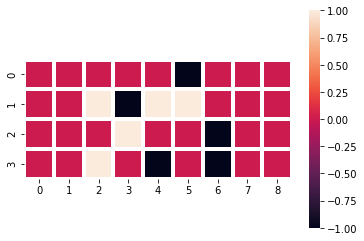

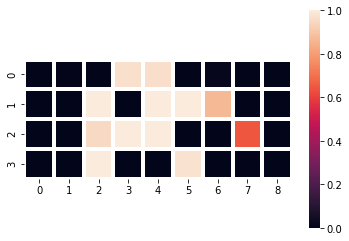

In [278]:
plt.figure()
sns.heatmap(b,linecolor='white',linewidth=3,square=True)
mask=rde.rde.layers[1].w.numpy()[0]
plt.figure()
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)

<AxesSubplot:>

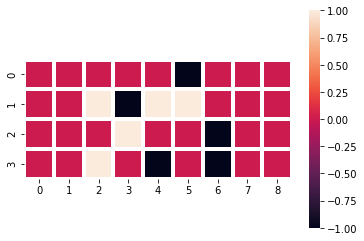

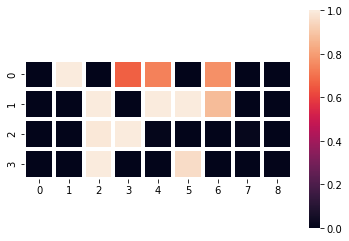

In [284]:
plt.figure()
sns.heatmap(b,linecolor='white',linewidth=3,square=True)
mask=rde.rde.layers[1].w.numpy()[0]
plt.figure()
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)

<AxesSubplot:>

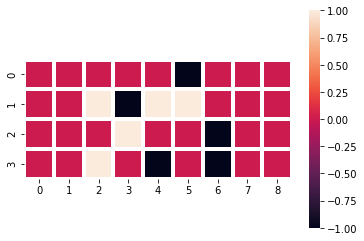

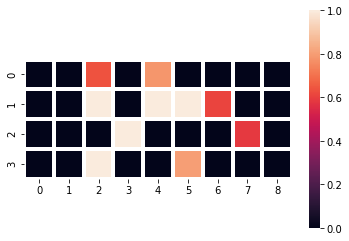

In [236]:
plt.figure()
sns.heatmap(b,linecolor='white',linewidth=3,square=True)
mask=rde.rde.layers[1].w.numpy()[0]
plt.figure()
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)

In [237]:
b = opt_boards[10]

In [238]:
model.predict(b[None,...])

[array([[3.2865207e-03, 6.8088355e-03, 4.8959162e-02, 5.1287701e-04,
         1.2969339e-02, 4.0674204e-05, 1.0622602e-02, 2.5300004e-03,
         1.8309592e-03, 2.3068914e-03, 1.9559464e-03, 2.7138023e-03,
         3.0002504e-06, 2.6706230e-05, 8.8014649e-06, 4.2488483e-01,
         1.4886259e-03, 1.6252508e-03, 6.5423094e-04, 2.2669111e-03,
         4.4141248e-01, 2.8196638e-07, 3.4879625e-03, 1.5180565e-04,
         3.0277122e-04, 8.7450654e-04, 6.0325267e-04, 5.6721224e-04,
         2.1035536e-03, 1.9153110e-03, 1.5738854e-02, 5.1741791e-04,
         3.2529684e-03, 1.2008158e-03, 1.5547909e-03, 8.2010514e-04]],
       dtype=float32),
 array([[0.95013183]], dtype=float32)]

In [242]:
import copy
b_cp = copy.copy(b)
b_cp[2,2] = -1
model.predict(b_cp[None,...])

[array([[7.30265072e-03, 3.90220545e-02, 2.63790903e-03, 1.55643309e-02,
         8.45058635e-03, 1.45189348e-03, 5.43504097e-02, 2.66068708e-03,
         3.47167975e-03, 3.89475096e-03, 1.58698186e-02, 2.59630848e-04,
         1.32538371e-05, 1.27062585e-05, 5.84457775e-05, 6.17672682e-01,
         2.90148659e-03, 3.73199256e-03, 2.83640856e-03, 5.98236267e-03,
         1.23841683e-05, 3.30452094e-05, 1.61564234e-03, 5.60482091e-04,
         5.43799251e-04, 1.96017115e-03, 2.81068101e-03, 3.44732148e-03,
         3.52610946e-02, 7.88107328e-03, 1.33987203e-01, 5.61154156e-04,
         1.03295194e-02, 1.17154990e-03, 6.35914644e-03, 5.31996833e-03]],
       dtype=float32),
 array([[-0.03734915]], dtype=float32)]

In [ ]:
##### plt.figure()
sns.heatmap(b,linecolor='white',linewidth=3,square=True)
mask=rde.rde.layers[1].w.numpy()[0]
plt.figure()
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)

<AxesSubplot:>

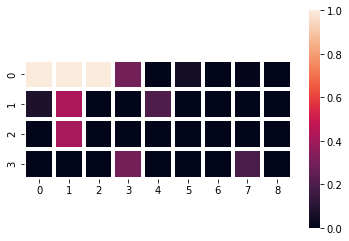

In [115]:
mask=rde.rde.layers[1].w.numpy()[0]
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)

In [103]:
new_weights[0]

array([[1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [106]:
b = game.getInitBoard()
b[0,:3]=-1

In [107]:
new_weights=[b[None,...]]+rde.rde.layers[1].get_weights()[1:]
rde.rde.layers[1].set_weights(new_weights)

In [108]:
rde.rde(input_boards)

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[-0.9875633 ],
       [ 0.04659623],
       [-0.01322917],
       [ 0.17464551],
       [-0.96810067],
       [-0.6240455 ],
       [-0.5745035 ],
       [-0.5333957 ],
       [-0.7331195 ],
       [-0.9904215 ],
       [ 0.12707306],
       [-0.01838364],
       [-0.469577  ],
       [-0.9249388 ],
       [ 0.00240578],
       [-0.91409934],
       [ 0.18257844],
       [-0.7142864 ],
       [-0.6420621 ],
       [-0.57300264],
       [-0.51471174],
       [ 0.10200144],
       [-0.36228445],
       [-0.41731423],
       [-0.7660134 ],
       [-0.35099155],
       [-0.61843354],
       [-0.9759993 ],
       [-0.98008484],
       [-0.11618728],
       [-0.62256265],
       [-0.989038  ],
       [-0.02681305],
       [-0.00771403],
       [-0.69573325],
       [-0.07492536],
       [-0.3205999 ],
       [-0.05536082],
       [-0.6732113 ],
       [ 0.26302853],
       [-0.02632506],
       [-0.89838964],
       [-0.9807484 ],
    

In [95]:
mask

array([[0.0000000e+00, 0.0000000e+00, 2.0759065e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 3.7585040e-05, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.4371775e-02,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

<AxesSubplot:>

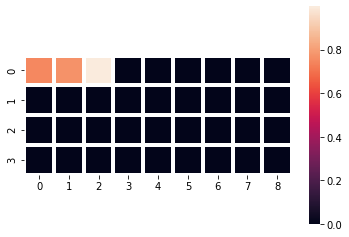

In [78]:
mask=rde.rde.layers[1].w.numpy()[0]
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)

In [79]:
mask

array([[0.7489701 , 0.77233046, 0.9982107 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)

<AxesSubplot:>

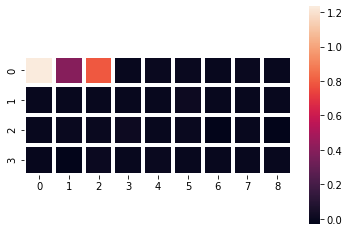

In [66]:
mask=rde.rde.layers[1].w.numpy()[0]
sns.heatmap(mask,linecolor='white',linewidth=3,square=True)